In [1]:
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast
import cv2
import matplotlib.pyplot as plt
import random
import torch
import torchvision.ops.boxes as bops
from PIL import Image
import uuid
from pathlib import Path

# TODOs

1. Functionality

   1. Implement in larger pipeline
      1. Attach to hydra config (synth config)
      2. Connect to database
      3. Add dataclasses


   2. Create more pots, backgrounds


2. Features
   1. transform cutouts
   2. more maps
   3. high-level sorting 
   4. compactness config

## Pot to Background

In [2]:
def check_negative_positions(h0, w0, pot):
    # check if h0 or w0 is negative and adjust if so
    if w0 < 0:
        pot = pot[:, abs(w0):]
        w0 = 0

    if h0 < 0:
        pot = pot[abs(h0):, :]
        h0 = 0
    return h0, w0, pot

def crop_pot2background(h0, w0, pot_h, pot_w, back_h, back_w, pot):
    """ Checks position of pot with background dimensions. 
        Cut pot if it extends beyond frame of background
    """
    if w0 + pot_w > back_w:
        back_w = back_w - w0
        pot = pot[:, :back_w]

    if h0 + pot_h > back_h:
        back_h = back_h - h0
        pot = pot[:back_h,:]
    
    return pot

def blend_pot(h0, w0, pot, zero_mask, back):
    pot_h, pot_w, _ = pot.shape    
    h1 = h0 + pot_h
    w1 = w0+ pot_w
    pot_mask = pot[..., 3:] / 255
    alpha_l = 1.0 - pot_mask

    back[h0:h1,w0:w1] = alpha_l * back[h0:h1,w0:w1] + pot_mask* pot 
    
    zero_mask[h0:h1,w0:w1] = (255) * pot_mask + zero_mask[h0:h1,w0:w1] * (1.0 - pot_mask)
    
    return back, h0, w0


def overlay_pot(h0, w0, pot, zero_mask, back):

    h0, w0, pot  = check_negative_positions(h0, w0, pot)
    
    back_h, back_w, _ = back.shape
    pot_h, pot_w, _ = pot.shape    
    
    pot = crop_pot2background(h0, w0, pot_h, pot_w, back_h, back_w, pot)
    # print(back)
    back, h0, w0 = blend_pot(h0, w0, pot, zero_mask, back)
    
    return back, h0, w0


In [9]:
def get_cutout(cutout):
    cutout = cv2.cvtColor(cv2.imread(cutout,cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
    alpha = np.sum(cutout, axis=-1) > 0
    alpha = np.uint8(alpha * 255)
    cutout = np.dstack((cutout, alpha))
    return cutout

def overlay_cutout(x0, y0, cutout, potted_back, zero_mask):
    cut_h , cut_w, _ = cutout.shape
    potback_h, potback_w, _ = potted_back.shape
    
    cutout = crop_pot2background(y0, x0, cut_h, cut_w, potback_h, potback_w, cutout)
    
    cut_h, cut_w, _ = cutout.shape    
    y1 = y0 + cut_h
    x1 = x0+ cut_w
    cutout_mask = cutout[..., 3:] / 255
    alpha_l = 1.0 - cutout_mask

    potted_back[y0:y1,x0:x1] = alpha_l * potted_back[y0:y1,x0:x1] + cutout_mask* cutout 

    zero_mask[y0:y1,x0:x1] = (1) * cutout_mask + zero_mask[y0:y1,x0:x1] * (1.0 - cutout_mask)

    zero_mask = zero_mask * 255

    return potted_back, zero_mask

def pot2cutout_position(topl_y, topl_x, potshape, cutshape):
    # pot positions and shape top left corner
    pot_h, pot_w, _ = potshape
    cut_h, cut_w, _ = cutshape
    cutx = int(((pot_w - cut_w) / 2) + topl_x)
    cuty = int(((pot_h - cut_h) / 2) + topl_y)
    
    return cutx, cuty

## Cutout to Pots

In [10]:
# Pot positioning
sixpot_map = {
    0:(1592, 1599),
    1:(1592, 4796),
    2:(1592, 7993),
    3:(4776, 1599),
    4:(4776, 4796),
    5:(4776, 7993)
}

def center2topleft( x, y, potshape):
    pot_h, pot_w, _ = potshape
    y = y - int(pot_h/2)
    x = x - int(pot_w/2)
    return x, y

def box_iou(box1, box2):
    box1 = torch.tensor([box1], dtype=torch.float)
    box2 = torch.tensor([box2], dtype=torch.float)
    iou = bops.box_iou(box1, box2)
    return iou

def get_boxes(x, y, potshape):
    pot_h, pot_w, _ = potshape
    x0, x1, y0, y1 = x, x + pot_w, y, y + pot_h
    bbox = [x0, y0, x1, y1] # top right corner, bottom left corner
    return bbox

def check_overlap(x, y,potshape, pot_positions):  # x = w ; h = y
    """Check overlap from list of previous bbox coordinates"""
    if not None in pot_positions:
        new_bbox = get_boxes(x, y, potshape)
        for y_new, x_new, oldpotshape in pot_positions:
            old_bbox = get_boxes(x_new, y_new, oldpotshape)
            
            iou = box_iou(old_bbox, new_bbox)    
            while iou > 0.05:
                x, y = x + random.randint(-2500, 2500), y + random.randint(-2000, 2000)
                new_bbox = get_boxes(x, y, potshape)
                iou = box_iou(old_bbox, new_bbox)
                print(iou)
        
        x, y = new_bbox[0], new_bbox[1]

    return x, y


def get_pot_positions(idx, potshape, pot_map, pot_positions, spread_factor):
    
    y, x = pot_map[idx]
    
    x, y = x + random.randint(-(spread_factor), spread_factor), y + random.randint(-(int(spread_factor/3)), (int(spread_factor/3)))
    
    x, y = center2topleft(x, y, potshape)
    
    x, y = check_overlap(x, y,potshape, pot_positions)
    
    return x, y

## Save Data

In [11]:
def create_synth_fname(backpath, potpath, cutpath):
    pass

def save_synth(res, mask, backpath, potpath, cutpath):
    savedir = "../data/temp/quick_synth_test/synth_results/"
    fstem = uuid.uuid4().hex
    fname = fstem + ".png"
    fmaskname = fstem + "_mask.png"
    savepath = Path(savedir,fname)
    savemask = Path(savedir,fmaskname)
    res = cv2.cvtColor(res, cv2.COLOR_RGBA2BGRA)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite(str(savepath), res)
    cv2.imwrite(str(savemask), mask)


## Load data

In [19]:
backpath = "../data/temp/quick_synth_test/backgrounds/background.jpg"
potp = "../data/temp/quick_synth_test/pots/row5_2.png"
cutouts = Path("../data/temp/quick_synth_test/cutouts").glob("*.png")

cutouts = [str(x) for x in cutouts]

back = cv2.resize(cv2.cvtColor(cv2.imread(backpath,cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA), (9592,6368))
backs = [back.copy(), back.copy(), back.copy(), back.copy()]
pot = cv2.cvtColor(cv2.imread(potp,cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)


## Pipeline

In [20]:
for back in backs:
    new_mask = np.zeros_like(back)
    cutout_mask = np.zeros_like(back)
    back_h, back_w, _ = back.shape
    pot_positions = []
    cutouts_fnames = []
    pot_fnames = []
    spread_factor = random.randint(2000, 3000)
    for idx, i in enumerate(range(0,6)): # number of pots per image
    
        topl_x, topl_y = get_pot_positions(idx, pot.shape, sixpot_map, pot_positions,spread_factor)

        # if topl_y > back_h or topl_x > back_w: # safe guard if pots positions go completely outiside frame
        #     continue
    
        potted_back, topl_y, topl_x = overlay_pot(topl_y, topl_x, pot, new_mask, back)
        
        pot_positions.append([topl_y, topl_x, pot.shape])
        
        cutout_choice = random.choice(cutouts)
        cutouts_fnames.append(Path(cutout_choice).stem)
        cutout = get_cutout(cutout_choice)
        
        cutx, cuty = pot2cutout_position(topl_y, topl_x, pot.shape, cutout.shape)
        
        pb_h, pb_w, _ = potted_back.shape

        if cuty > pb_h or cutx > pb_w: # safe guard if pots positions go completely outiside frame
            continue
        res, mask = overlay_cutout(cutx, cuty, cutout, potted_back, cutout_mask)

    save_synth(res, mask[:,:,0], "", "", "")
    


tensor([[0.2555]])
tensor([[0.3842]])
tensor([[0.0203]])
tensor([[0.]])
tensor([[0.0477]])
tensor([[0.3018]])
tensor([[0.]])
tensor([[0.2037]])
tensor([[0.0769]])
tensor([[0.]])


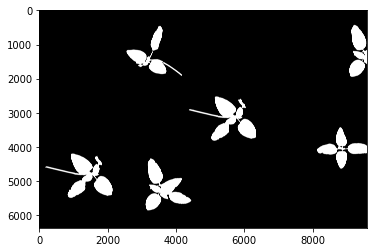

In [332]:
plt.imshow(mask[:,:,0], cmap = "gray")